In [1]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
class MLP(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.BatchNorm1d(hid_dim),   
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.BatchNorm1d(hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, out_dim))
    
    def forward(self, x):
        return self.net(x)

    
def test():
    x = torch.randn((100, 1000))
    model = MLP(1000, 200, 9)
    x_hat = model(x)
    print(x_hat.shape)
test()

torch.Size([100, 9])


In [4]:
rootdir = './material.pkl'

id = []
xrd = np.empty([41100,1000])
params = np.empty([41100,6])

with open(rootdir, 'rb') as f:
    material = pickle.load(f)
    for i, k in enumerate(material.keys()):
        id.append(k)
        xrd[i] = np.array(material[k]['xrd'])[0]
        params[i] = np.array(material[k]['param'])

In [5]:
def get_lattice_vectors(a, b, c, alpha, beta, gamma):
    '''http://gisaxs.com/index.php/Unit_cell'''
    
    alpha = np.radians(alpha)
    beta = np.radians(beta)
    gamma = np.radians(gamma)
    
    # a 
    a1 = a
    a2 = 0
    a3 = 0
    
    # b
    b1 = b * np.cos(gamma)
    b2 = b * np.sin(gamma)
    b3 = 0
    
    # c
    c1 = c * np.cos(beta)
    c2 = c * (np.cos(alpha) - np.cos(beta)*np.cos(gamma)) / np.sin(gamma)
    c3 = c * np.sqrt(1 - np.cos(beta)**2 - ((np.cos(alpha) - np.cos(beta)*np.cos(gamma)) / np.sin(gamma))**2)

    a_ = np.array([a1, a2, a3])
    b_ = np.array([b1, b2, b3])
    c_ = np.array([c1, c2, c3])
    
    return a_, b_, c_

In [6]:
abc = np.empty([41100,3,3])

for i, param in enumerate(params):
    a, b, c = get_lattice_vectors(
        param[0], 
        param[1],
        param[2],
        param[3],
        param[4],
        param[5])
    
    abc[i][:,0] = a
    abc[i][:,1] = b
    abc[i][:,2] = c


In [7]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super(Dataset, self).__init__()
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.X[idx], self.y[idx]
    
    
X, y = xrd, abc
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
dataset = Dataset(X, y)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024)
dataloaders = {'Train': trainloader, 'Val': testloader}

In [8]:
def mse(y, y_pred):
    return nn.MSELoss(reduction='mean')(y, y_pred)

In [11]:
model = MLP(1000, 200, 9)

train_loss_list = []
test_loss_list = []

for epoch in range(1, 200 + 1):

    # split epochs into training and validation phase
    for phase in ['Train', 'Val']:
        if phase == 'Train':
            optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
            model.train(True)
        else:
            model.train(False)

        # mini batch training
        train_loss = 0
        test_loss = 0
        for batch, (X, y) in enumerate(dataloaders[phase]):
            optimizer.zero_grad()

            X, y = X.float(), y.float()
            
            # forward propagation
            y_pred = model(X)
            y_pred = y_pred.view(y_pred.shape[0], 3, 3)
            
            loss = mse(y, y_pred)
            train_loss += loss.item()
            test_loss += loss.item()

            # optimization step only in training phase
            if phase == 'Train':
                loss.backward()
                optimizer.step()

                # print progress
                if batch == len(trainloader) - 1:
                    print('Epoch: {}, Train Loss: {:.3f}'.format(
                        epoch,
                        train_loss / len(trainloader)))
                    train_loss_list.append(train_loss / len(trainloader))
                    train_loss = 0
            
            else:
                if batch == len(testloader) - 1:
                    print('Epoch: {}, Test Loss: {:.3f}'.format(
                        epoch,
                        test_loss / len(testloader)))
                    test_loss_list.append(test_loss / len(testloader))
                    test_loss = 0

Epoch: 1, Train Loss: 12.777
Epoch: 1, Test Loss: 7.377
Epoch: 2, Train Loss: 6.855
Epoch: 2, Test Loss: 6.327
Epoch: 3, Train Loss: 6.310
Epoch: 3, Test Loss: 6.119
Epoch: 4, Train Loss: 5.978
Epoch: 4, Test Loss: 5.988
Epoch: 5, Train Loss: 5.724
Epoch: 5, Test Loss: 5.901
Epoch: 6, Train Loss: 5.523
Epoch: 6, Test Loss: 5.857
Epoch: 7, Train Loss: 5.299
Epoch: 7, Test Loss: 6.170
Epoch: 8, Train Loss: 5.164
Epoch: 8, Test Loss: 5.699
Epoch: 9, Train Loss: 5.069
Epoch: 9, Test Loss: 5.586
Epoch: 10, Train Loss: 4.972
Epoch: 10, Test Loss: 5.526
Epoch: 11, Train Loss: 4.787
Epoch: 11, Test Loss: 5.543
Epoch: 12, Train Loss: 4.628
Epoch: 12, Test Loss: 5.358
Epoch: 13, Train Loss: 4.497
Epoch: 13, Test Loss: 5.533
Epoch: 14, Train Loss: 4.469
Epoch: 14, Test Loss: 5.619
Epoch: 15, Train Loss: 4.317
Epoch: 15, Test Loss: 5.402
Epoch: 16, Train Loss: 4.261
Epoch: 16, Test Loss: 5.503
Epoch: 17, Train Loss: 4.196
Epoch: 17, Test Loss: 5.350
Epoch: 18, Train Loss: 4.165
Epoch: 18, Test Los

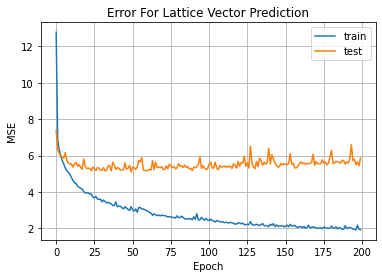

In [12]:
# plot average MSE over all iterations
plt.title("Error For Lattice Vector Prediction")
plt.plot(train_loss_list, label='train')
plt.plot(test_loss_list, label='test')
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid()
plt.legend()